In [1]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
train=pd.read_csv("./churn_prediction_data/train.csv")
test=pd.read_csv("./churn_prediction_data/test.csv")

In [3]:
train["Exited"].value_counts()

0    6368
1    1632
Name: Exited, dtype: int64

## 資料前處理

In [4]:
#ID取前四個數字
train["ID"]=train['CustomerId'].astype(str).str[:5].astype(int)
#將財務商品整合成兩類，大於2個、少於等於2個
train["is_4"]=train['NumOfProducts'].apply(lambda x: 1 if x >2  else 0)
#性別數值化(男生0、女生1)
train['Gender']=train['Gender'].apply(lambda x: 1 if x =="male"  else 0)
train["greater than 70000"]=train["Balance"].apply(lambda x: 1 if x >70000  else 0)

In [5]:
#將名字數值化
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train['Surname'].append(test['Surname']))
train["NAME_ID"]=pd.Series(le.transform(train['Surname']))

In [82]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
pca.fit(train[["Balance","EstimatedSalary"]])
#train["money"] = pca.transform(train[["Balance","EstimatedSalary"]])

PCA(n_components=1)

In [424]:
moneys=pd.DataFrame(pca.transform(train[["Balance","EstimatedSalary"]]),columns=['money1'])
#moneys=pd.DataFrame(pca.transform(train[["Balance","EstimatedSalary"]]),columns=['money1', 'money2'])

In [425]:
#選擇重要的特徵
select_data=train[["CreditScore","Balance","Tenure","Gender","IsActiveMember",'Age','NumOfProducts']]

In [426]:
#國家dummy variable
features_dummies=pd.get_dummies(train["Geography"])

In [427]:
#合併資料
#data=select_data
data=pd.concat([select_data, features_dummies,moneys],axis=1)

In [428]:
data

,CreditScore,Balance,Tenure,Gender,IsActiveMember,Age,NumOfProducts,France,Germany,Spain,money1
0,720,114051.97,5,0,1,38,2,0,0,1,13784.383558
1,682,62397.41,4,0,0,54,1,1,0,0,-37593.455871
2,672,119903.67,5,0,1,31,1,1,0,0,20694.439982
3,592,104257.86,4,0,0,40,1,0,0,1,4136.517003
4,753,120387.73,5,0,1,42,1,0,0,1,20903.401084
...,...,...,...,...,...,...,...,...,...,...,...
7995,568,121079.60,6,0,1,35,2,1,0,0,21532.227588
7996,602,145846.07,7,0,0,45,1,0,1,0,45202.194321
7997,679,132810.01,5,0,0,43,1,0,0,1,33499.446898
7998,715,118729.45,4,0,0,38,1,1,0,0,17950.374014


## 切訓練集/測試集

In [536]:
#切割資料
train_data,test_data,train_labels,test_labels=train_test_split(data,train["Exited"],test_size=0.005,stratify=train["Exited"])

In [537]:
train_labels = np.array(train_labels)
train_data =  np.array(train_data)
test_labels= np.array(test_labels)
test_data = np.array(test_data)

# 處理資料不平衡

In [431]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
train_data, train_labels = sm.fit_resample(train_data, train_labels)

## 利用XGBClassifier

In [538]:
from xgboost.sklearn import XGBClassifier
xgb = XGBClassifier()
xgb.fit(train_data,train_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [539]:
xgb.score(train_data,train_labels)

0.9368090452261306

In [540]:
xgb.score(test_data,test_labels)

0.95

<Figure size 432x288 with 0 Axes>

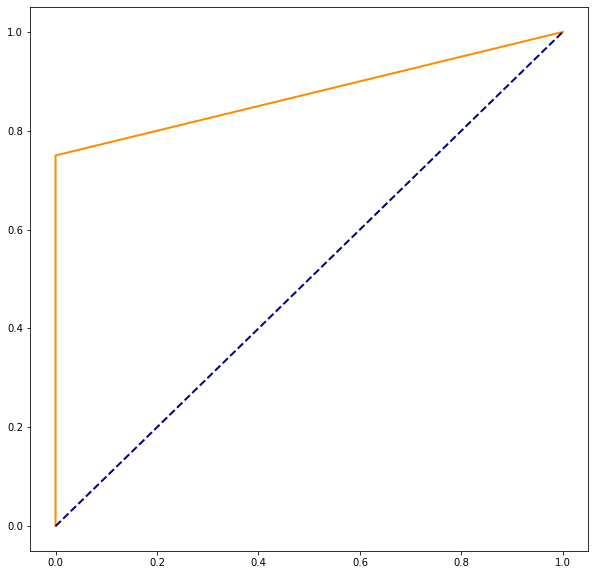

In [541]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr,tpr,threshold =roc_curve(test_labels, xgb.predict(test_data))
roc_auc = auc(fpr,tpr) ###計算auc的值 
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.show()

In [542]:
roc_auc

0.875

## test資料預測

In [543]:
#test資料前處理
test["ID"]=test['CustomerId'].astype(str).str[:4].astype(int)
test["is_4"]=test['NumOfProducts'].apply(lambda x: 1 if x >2  else 0)
test["NAME_ID"]=pd.Series(le.transform(test['Surname']))
test['Gender']=test['Gender'].apply(lambda x: 1 if x =="male"  else 0)
test["greater than 70000"]=test["Balance"].apply(lambda x: 1 if x >70000  else 0)

In [544]:
#PCA轉換
moneys_1=pd.DataFrame(pca.transform(test[["Balance","EstimatedSalary"]]),columns=['money1'])
#moneys_1=pd.DataFrame(pca.transform(test[["Balance","EstimatedSalary"]]),columns=['money1', 'money2'])

In [545]:
#特徵選擇
select_data=test[["CreditScore","Balance","Tenure","Gender","IsActiveMember",'Age','NumOfProducts']]

In [546]:
#特徵dummy
features_dummies=pd.get_dummies(test["Geography"])

In [547]:
#合併資料
data=pd.concat([select_data, features_dummies,moneys_1],axis=1)

In [548]:
data.columns=['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10']

In [549]:
#預測結果
xgb.predict(data)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [550]:
#預測為1的比例
sum(xgb.predict(data))/2000

0.143

## 匯出資料

In [551]:
#xgboost
d = {"RowNumber":test.RowNumber,"Exited":xgb.predict(data)}
df = pd.DataFrame(d)
df.to_csv("./output/xgboost7.csv")